# Portfolio Optimization with Higher Order Moments

### Importing stock prices and calculating returns

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
import cplex
from cplex.exceptions import CplexError
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize

In [4]:
# List out tickers for MAANG stocks
tickers = ['META','AAPL','AMZN','NFLX','GOOGL']
# Download historical adjusted closing stock prices from yahoo finance
data = yf.download(tickers, start = '2015-01-01', end = '2025-01-01')['Close']
# Compute and display daily log returns
log_returns = np.log(data / data.shift(1))
print(log_returns)

[*********************100%***********************]  5 of 5 completed

Ticker          AAPL      AMZN     GOOGL      META      NFLX
Date                                                        
2015-01-02       NaN       NaN       NaN       NaN       NaN
2015-01-05 -0.028576 -0.020731 -0.019238 -0.016192 -0.052238
2015-01-06  0.000094 -0.023098 -0.024989 -0.013565 -0.017269
2015-01-07  0.013925  0.010544 -0.002945  0.000000  0.005178
2015-01-08  0.037703  0.006813  0.003478  0.026309  0.021946
...              ...       ...       ...       ...       ...
2024-12-24  0.011413  0.017573  0.007575  0.013084  0.022425
2024-12-26  0.003171 -0.008770 -0.002604 -0.007266 -0.008598
2024-12-27 -0.013331 -0.014641 -0.014626 -0.005884 -0.018115
2024-12-30 -0.013352 -0.011010 -0.007917 -0.014391 -0.007876
2024-12-31 -0.007083 -0.008668 -0.010196 -0.009739 -0.010169

[2516 rows x 5 columns]


### Necessary Statistics for Stock Returns

<img src="mvsk.png">

In [7]:
# Calculate necessary statistics for each stock
mean = log_returns.mean()
variance = log_returns.var()
skewness = log_returns.apply(lambda x: ((x - x.mean()) / x.std())**3).mean()
kurtosis = log_returns.apply(lambda x: ((x - x.mean()) / x.std())**4).mean()

# Create a pandas dataframe
stats_df = pd.DataFrame()

# Assign columns with stats data
stats_df['Stocks'] = tickers
stats_df['Mean'] = mean.tolist()
stats_df['Variance'] = variance.tolist()
stats_df['Skewness'] = skewness.tolist()
stats_df['Kurtosis'] = kurtosis.tolist()

# Display the results
stats_df

,Stocks,Mean,Variance,Skewness,Kurtosis
0,META,0.000927,0.000322,-0.200511,8.439355
1,AAPL,0.001056,0.000423,0.157732,8.784280
2,AMZN,0.000784,0.000321,0.017101,9.174857
3,NFLX,0.000801,0.000569,-1.263085,30.590890
4,GOOGL,0.001147,0.000773,-1.376466,32.701001


#### Calculation of Coskewness(M3) and Cokurtosis(M4) Matrices

<img src="coskew_cokurt.png">

In [10]:
# Calculate variance-covariance matrix
covariance_mtx = log_returns.cov()

# Functions to calculate coskewness and cokurtosis between two assets
def calculate_coskewness(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    
    coskewness = np.mean(((x - mean_x) / std_x) * ((y - mean_y) / std_y)**2)
    return coskewness

def calculate_cokurtosis(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    
    cokurtosis = np.mean(((x - mean_x) / std_x) * ((y - mean_y) / std_y)**3)
    return cokurtosis

In [11]:
# Initialize empty matrices for skewness-coskewness and kurtosis-cokurtosis
coskewness_mtx = np.zeros((len(tickers), len(tickers)))
cokurtosis_mtx = np.zeros((len(tickers), len(tickers)))

# Calculate the above two matrices
for i in range(len(tickers)):
    for j in range(i, len(tickers)):
        # Diagonal: Skewness and Kurtosis
        if i == j:
            coskewness_mtx[i, j] = np.mean(((log_returns[tickers[i]] - np.mean(log_returns[tickers[i]])) / np.std(log_returns[tickers[i]]))**3)
            cokurtosis_mtx[i, j] = np.mean(((log_returns[tickers[i]] - np.mean(log_returns[tickers[i]])) / np.std(log_returns[tickers[i]]))**4)
        # Off-diagonal: Coskewness and Cokurtosis
        else:
            coskewness_mtx[i, j] = calculate_coskewness(log_returns[tickers[i]], log_returns[tickers[j]])
            coskewness_mtx[j, i] = coskewness_mtx[i, j]
            
            cokurtosis_mtx[i, j] = calculate_cokurtosis(log_returns[tickers[i]], log_returns[tickers[j]])
            cokurtosis_mtx[j, i] = cokurtosis_mtx[i, j]

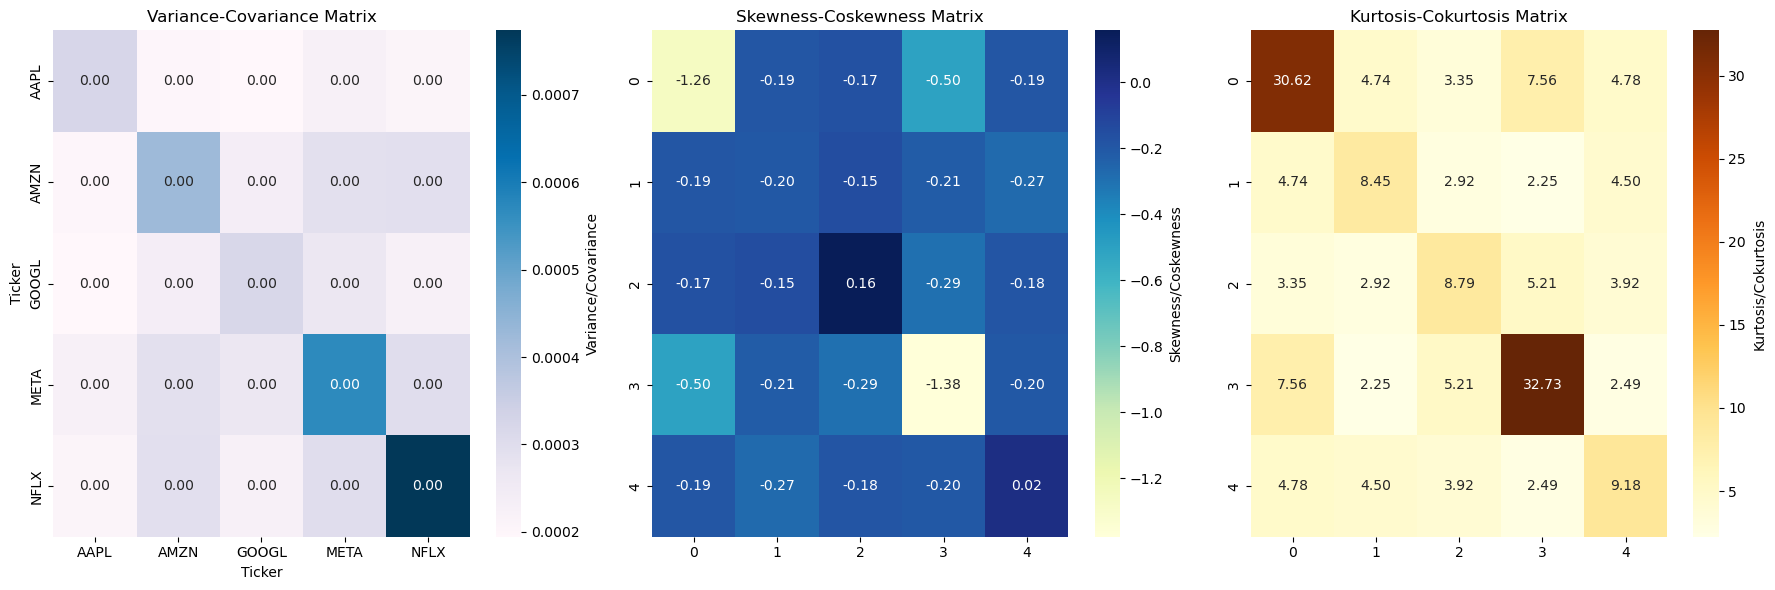

In [12]:
# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Variance-Covariance Heatmap
sns.heatmap(covariance_mtx, annot = True, cmap = 'PuBu', fmt = '.2f', ax = axes[0], cbar_kws = {'label': 'Variance/Covariance'})
axes[0].set_title('Variance-Covariance Matrix')

# Skewness-Coskewness Heatmap
sns.heatmap(coskewness_mtx, annot = True, cmap = 'YlGnBu', fmt = '.2f', ax = axes[1], cbar_kws = {'label': 'Skewness/Coskewness'})
axes[1].set_title('Skewness-Coskewness Matrix')

# Kurtosis-Cokurtosis Heatmap
sns.heatmap(cokurtosis_mtx, annot = True, cmap = 'YlOrBr', fmt = '.2f', ax = axes[2], cbar_kws = {'label': 'Kurtosis/Cokurtosis'})
axes[2].set_title('Kurtosis-Cokurtosis Matrix')

# Adjust the layout
plt.tight_layout()
plt.show()

### Portfolio Performance Metrics before Optimization

In [14]:
# Function to calculate portfolio performance metrics
def portfolio_performance(weights, mean, covariance_mtx, skewness, kurtosis):
    # Portfolio return (mean)
    portfolio_return = np.dot(weights, mean)
    
    # Portfolio variance
    portfolio_variance = np.dot(weights.T, np.dot(covariance_mtx, weights))
    
    # Portfolio skewness
    portfolio_skewness = np.dot(weights, skewness)
    
    # Portfolio kurtosis
    portfolio_kurtosis = np.dot(weights, kurtosis)
    
    return portfolio_return, portfolio_variance, portfolio_skewness, portfolio_kurtosis

## Mean-Variance-Skewness-Kurtosis Portfolio Optimization

### Method 1: SciPy Package

In [17]:
# Define the objective function (Polynomial Goal Programming)
def objective(weights, mean, covariance_mtx, skewness, kurtosis):
    # Extract portfolio performance metrics
    portfolio_return, portfolio_variance, portfolio_skewness, portfolio_kurtosis = portfolio_performance(
        weights, mean, covariance_mtx, skewness, kurtosis)
    
    # Maximize mean and skewness, minimize variance and kurtosis
    return -portfolio_return + portfolio_variance - portfolio_skewness + portfolio_kurtosis

# Constraints: sum of weights = 1, and weights between 0 and 1
def constraint(weights):
    return np.sum(weights) - 1

# Bounds: 0 <= weight <= 1 for each asset
bounds = [(0, 1)] * len(tickers)

# Initial guess (equal weights)
initial_guess = np.ones(len(tickers)) / len(tickers)

# Constraints for optimization (weights sum to 1)
constraints = ({'type': 'eq', 'fun': constraint})

In [18]:
# Solve the optimization problem
result = minimize(objective, initial_guess, args = (mean, covariance_mtx, skewness, kurtosis), 
                  method = 'SLSQP', bounds = bounds, constraints = constraints)

# Display the results
if result.success:
    optimal_weights = result.x
    print("\nOptimal Portfolio Weights:")
    for i, ticker in enumerate(tickers):
        print(f"{ticker}: {optimal_weights[i]:.4f}")
else:
    print("Optimization failed:", result.message)


Optimal Portfolio Weights:
META: 0.0000
AAPL: 1.0000
AMZN: 0.0000
NFLX: 0.0000
GOOGL: 0.0000


### Method 2: Using Gurobi Solver

In [20]:
# Create a Gurobi model
model = gp.Model("Portfolio Optimization")

# Decision variables: portfolio weights
weights = model.addVars(len(tickers), lb = 0, ub = 1, name = "weights")

# Objective function: Maximize mean returns - Minimize variance + Maximize skewness - Minimize kurtosis
mean_expr = gp.quicksum(mean[i] * weights[i] for i in range(len(tickers)))
variance_expr = gp.quicksum(weights[i] * weights[j] * covariance_mtx.iloc[i, j] for i in range(len(tickers)) for j in range(len(tickers)))
skewness_expr = gp.quicksum(skewness[i] * weights[i] for i in range(len(tickers)))
kurtosis_expr = gp.quicksum(kurtosis[i] * weights[i] for i in range(len(tickers)))

Restricted license - for non-production use only - expires 2026-11-23


C:\Users\sahav\AppData\Local\Temp\ipykernel_33016\2690697045.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_expr = gp.quicksum(mean[i] * weights[i] for i in range(len(tickers)))
C:\Users\sahav\AppData\Local\Temp\ipykernel_33016\2690697045.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  skewness_expr = gp.quicksum(skewness[i] * weights[i] for i in range(len(tickers)))
C:\Users\sahav\AppData\Local\Temp\ipykernel_33016\2690697045.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame b

In [21]:
# Reformulate the objective (maximize mean, minimize variance, skewness, and kurtosis)
# Maximize mean and skewness, minimize variance and kurtosis
model.setObjective(mean_expr - variance_expr + skewness_expr - kurtosis_expr, GRB.MAXIMIZE)

# Constraints: sum of weights = 1
model.addConstr(gp.quicksum(weights[i] for i in range(len(tickers))) == 1, "sum_of_weights")

# Optimize the model
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x5fd60762
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+00, 3e+01]
  QObjective range [6e-04, 2e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 5 columns, 5 nonzeros
Presolved model has 15 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 4
 AA' NZ     : 1.000e+01
 Factor NZ  : 1.500e+01
 Factor Ops : 5.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.61338902e+

In [22]:
# Display results
if model.status == GRB.OPTIMAL:
    print("\nOptimal Portfolio Weights:")
    for i, ticker in enumerate(tickers):
        print(f"{ticker}: {weights[i].x:.4f}")
else:
    print("Optimization was not successful.")


Optimal Portfolio Weights:
META: 0.0000
AAPL: 1.0000
AMZN: 0.0000
NFLX: 0.0000
GOOGL: 0.0000


### Method 3: Using Cplex Solver

In [24]:
# Create a CPLEX optimization model
model = cplex.Cplex()
model.set_problem_type(cplex.Cplex.problem_type.LP)

# Define the number of tickers
n = len(tickers)

# Add the decision variables (weights) to the model
model.variables.add(names = tickers, types = ['C']*n, lb = [0]*n, ub = [1]*n)  # 'C' stands for continuous variables

range(0, 5)

In [25]:
# Now, we define the objective components
mean_expr = np.array([mean[i] for i in range(n)])
variance_expr = np.array([covariance_mtx.iloc[i, i] for i in range(n)])
skewness_expr = np.array([skewness[i] for i in range(n)])
kurtosis_expr = np.array([kurtosis[i] for i in range(n)])

# Combine the objective components (ensure they are of length n)
obj_coeffs = mean_expr - variance_expr + skewness_expr - kurtosis_expr

# Add the objective function to the model (using decision variables and coefficients)
model.objective.set_linear(list(zip(tickers, obj_coeffs.tolist())))

# Set the objective sense to maximize
model.objective.set_sense(model.objective.sense.maximize)

# Add the constraint: sum of weights = 1
model.linear_constraints.add(lin_expr = [cplex.SparsePair(ind = tickers, val = [1]*n)], senses = ['E'], rhs = [1])

C:\Users\sahav\AppData\Local\Temp\ipykernel_33016\88087118.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_expr = np.array([mean[i] for i in range(n)])
C:\Users\sahav\AppData\Local\Temp\ipykernel_33016\88087118.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  skewness_expr = np.array([skewness[i] for i in range(n)])
C:\Users\sahav\AppData\Local\Temp\ipykernel_33016\88087118.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

range(0, 1)

In [26]:
# Step 8: Solve the problem using CPLEX
model.solve()

# Step 9: Get and print the results
solution = model.solution
weights = solution.get_values()

# Output the portfolio weights
print(f"Optimal Portfolio Weights: {dict(zip(tickers, weights))}")

Version identifier: 22.1.2.0 | 2024-12-09 | 8bd2200c8
CPXPARAM_Read_DataCheck                          1
Found incumbent of value -8.639261 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 5 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 20 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)
Optimal Portfolio Weights: {'META': 0.0, 'AAPL': 1.0, 'AMZN': 0.0, 'NFLX': 0.0, 'GOOGL': 0.0}


## Optimal Portfolio Performance Analysis

In [28]:
# Calculating optimal portfolio statistics
expected_portfolio_return = np.dot(weights, mean)
portfolio_variance = np.dot(weights, np.dot(covariance_mtx, weights))
portfolio_skewness = np.dot(weights, skewness)
portfolio_kurtosis = np.dot(weights, kurtosis)

# Displaying the results
print("Optimal Portfolio Performance:")
print(f"Expected Return: {expected_portfolio_return}")
print(f"Portfolio Variance: {portfolio_variance}")
print(f"Portfolio Skewness: {portfolio_skewness}")
print(f"Portfolio Kurtosis: {portfolio_kurtosis}")

Optimal Portfolio Performance:
Expected Return: 0.0010555851256073146
Portfolio Variance: 0.0004232688063444076
Portfolio Skewness: 0.15773214857206805
Portfolio Kurtosis: 8.784280433918354


In [48]:
# Annualized Parameters
annualized_portfolio_return = expected_portfolio_return * 252
annualized_portfolio_variance = portfolio_variance * 252
print(f"Annualized Portfolio Return: {annualized_portfolio_return}")
print(f"Annualized Portfolio Variance: {annualized_portfolio_variance}")
print(f"Sharpe Ratio: {(annualized_portfolio_return - 0.04) / annualized_portfolio_variance}")

Annualized Portfolio Return: 0.2660074516530433
Annualized Portfolio Variance: 0.10666373919879071
Sharpe Ratio: 2.118878011878339
